In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Import manquant
from datetime import datetime
import numpy as np
import seaborn as sns
df = pd.read_csv("ValueCo data extract - ENSAE research project.csv")

In [8]:
print(df.columns)

Index(['isin', 'name', 'sector', 'industry', 'country', 'region', 'score_kind',
       'first_quartile', 'consensus', 'third_quartile', 'strength', 'period'],
      dtype='object')


In [9]:
print(df.head())

           isin                        name       sector  \
0  IE0002424939  Dcc public limited company  Industrials   
1  FR0010451203                    Rexel sa  Industrials   
2  FR0010451203                    Rexel sa  Industrials   
3  FR0000120503                 Bouygues sa  Industrials   
4  CH0002432174        Bucher industries ag  Industrials   

                                  industry      country  region score_kind  \
0      Oil and Gas Retail and Distribution      Ireland  Europe        ESG   
1        Electrical Equipment Distributors       France  Europe          S   
2        Electrical Equipment Distributors       France  Europe          E   
3    Integrated Telecommunication Services       France  Europe          G   
4  Construction Machinery and Heavy Trucks  Switzerland  Europe          E   

   first_quartile  consensus  third_quartile  strength      period  
0            52.4       52.4            52.4     100.0  2020-03-01  
1            60.4       60.4    

Pour obtenir tous les scores d'une entreprise particulière (ici Rexel sa):

In [ ]:
def get_company_data(company_name):
    company_df = df[df['name'] == company_name]  
    return company_df

company = "Rexel sa"  
result = get_company_data(company)

In [ ]:
moyenne_scores = df.groupby("period")["consensus"].mean()
print(moyenne_scores)

Date minimum: 2019-01-01
Date maximum: 2025-02-01

Tous les mois entre ces dates (74 mois):
['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02']

Mois présents dans les données (74 mois):
['2019-01', '2019-02', '2019-03', '2019-04', '2019

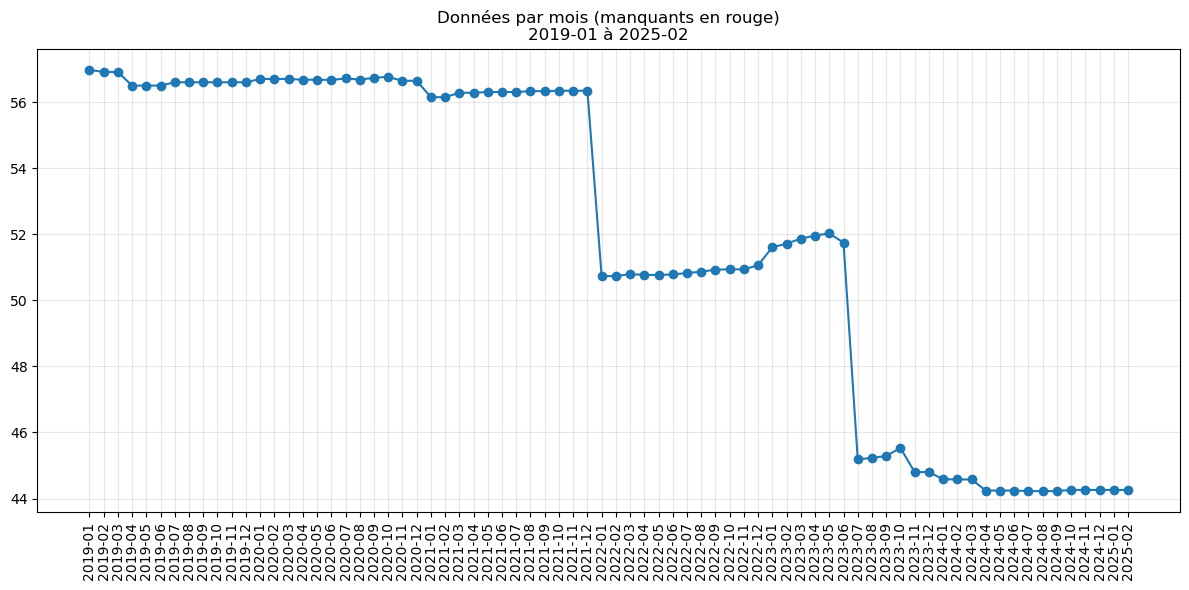

In [12]:
df['period'] = pd.to_datetime(df['period'])
min_date = df['period'].min()
max_date = df['period'].max()
print(f"Date minimum: {min_date.strftime('%Y-%m-%d')}")
print(f"Date maximum: {max_date.strftime('%Y-%m-%d')}")
all_months = pd.date_range(
    start=min_date.replace(day=1),  # Premier jour du mois de début
    end=max_date.replace(day=1),    # Premier jour du mois de fin
    freq='MS'  # MS = Month Start
)
print(f"\nTous les mois entre ces dates ({len(all_months)} mois):")
print(all_months.strftime('%Y-%m').tolist())
existing_months = df['period'].dt.to_period('M').unique()
print(f"\nMois présents dans les données ({len(existing_months)} mois):")
print(sorted([str(month) for month in existing_months]))
all_periods = set(pd.PeriodIndex(all_months, freq='M'))
existing_periods = set(existing_months)
missing_months = sorted(list(all_periods - existing_periods))

print(f"\nMois manquants ({len(missing_months)}):")
for month in missing_months:
    print(str(month))
plt.figure(figsize=(12, 6))
monthly_data = df.groupby(df['period'].dt.to_period('M'))['consensus'].mean()
plt.plot(monthly_data.index.astype(str), monthly_data.values, 
         'o-', label='Données existantes')
for month in missing_months:
    plt.axvline(x=str(month), color='red', alpha=0.3, linestyle='--')

plt.title(f"Données par mois (manquants en rouge)\n{min_date.strftime('%Y-%m')} à {max_date.strftime('%Y-%m')}")
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

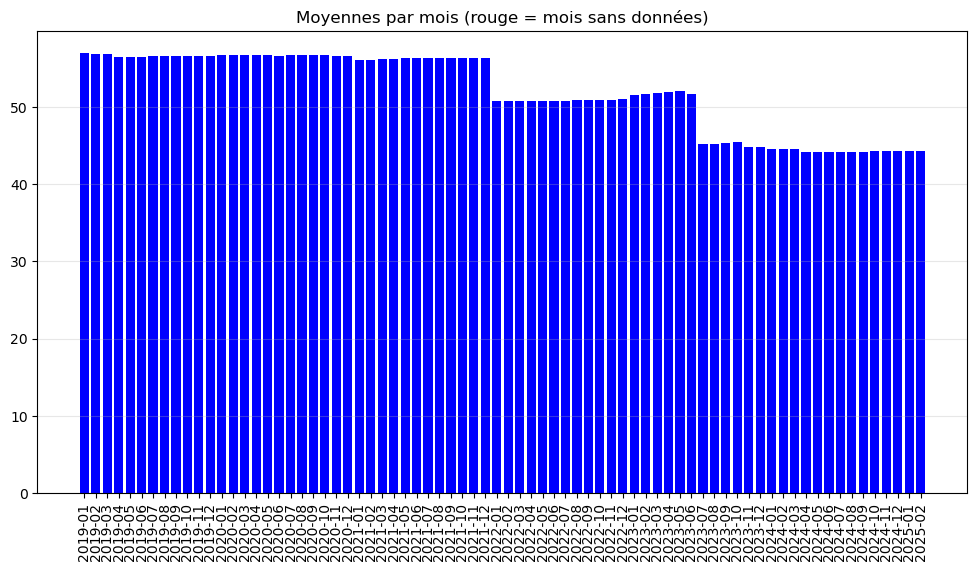

In [13]:
all_months = pd.period_range(
    start=df['period'].min().to_period('M'),
    end=df['period'].max().to_period('M'),
    freq='M'
)

moyennes_complete = (
    df.groupby(df['period'].dt.to_period('M'))['consensus']
    .mean()
    .reindex(all_months)
)

# Visualisation avec gestion des manquants
plt.figure(figsize=(12, 6))
bars = plt.bar(moyennes_complete.index.astype(str), 
               moyennes_complete.fillna(0),  # Remplacer NaN par 0
               color=['red' if pd.isna(x) else 'blue' for x in moyennes_complete])

plt.title("Moyennes par mois (rouge = mois sans données)")
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.show()

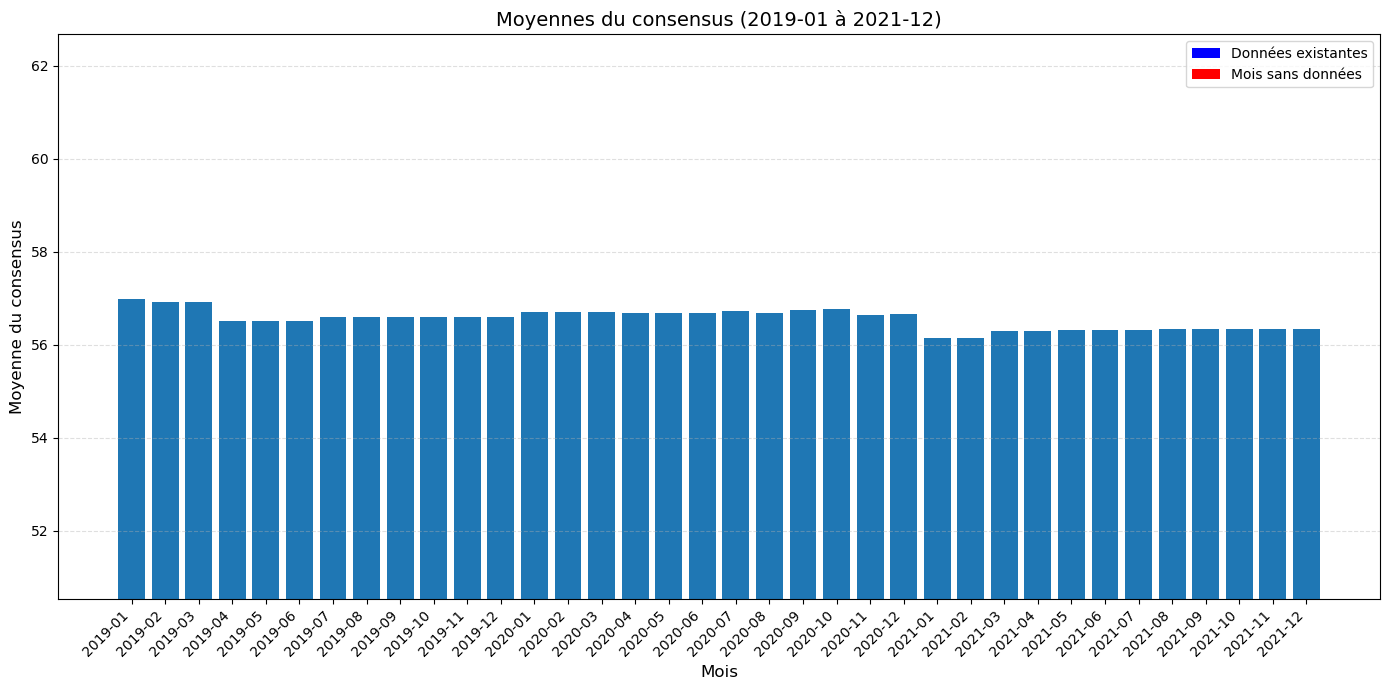

In [17]:
df['period'] = pd.to_datetime(df['period'])
period_start = '2019-01'
period_end = '2021-12'

# Création de l'échelle temporelle complète
full_months = pd.period_range(start=period_start, end=period_end, freq='M')

# Calcul des moyennes avec tous les mois forcés
moyennes = (
    df.groupby(df['period'].dt.to_period('M'))['consensus']
    .mean()
    .reindex(full_months)
)
plt.figure(figsize=(14, 7))
plt.bar(moyennes.index.astype(str), moyennes.fillna(0))
plt.title(f"Moyennes du consensus ({period_start} à {period_end})", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Moyenne du consensus", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(handles=legend_elements)
plt.axhline(0, color='black', linewidth=0.8)
if not moyennes.isna().all():
    y_min = moyennes.min() * 0.9 if moyennes.min() > 0 else moyennes.min() * 1.1
    y_max = moyennes.max() * 1.1 if moyennes.max() > 0 else moyennes.max() * 0.9
    plt.ylim(y_min, y_max)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


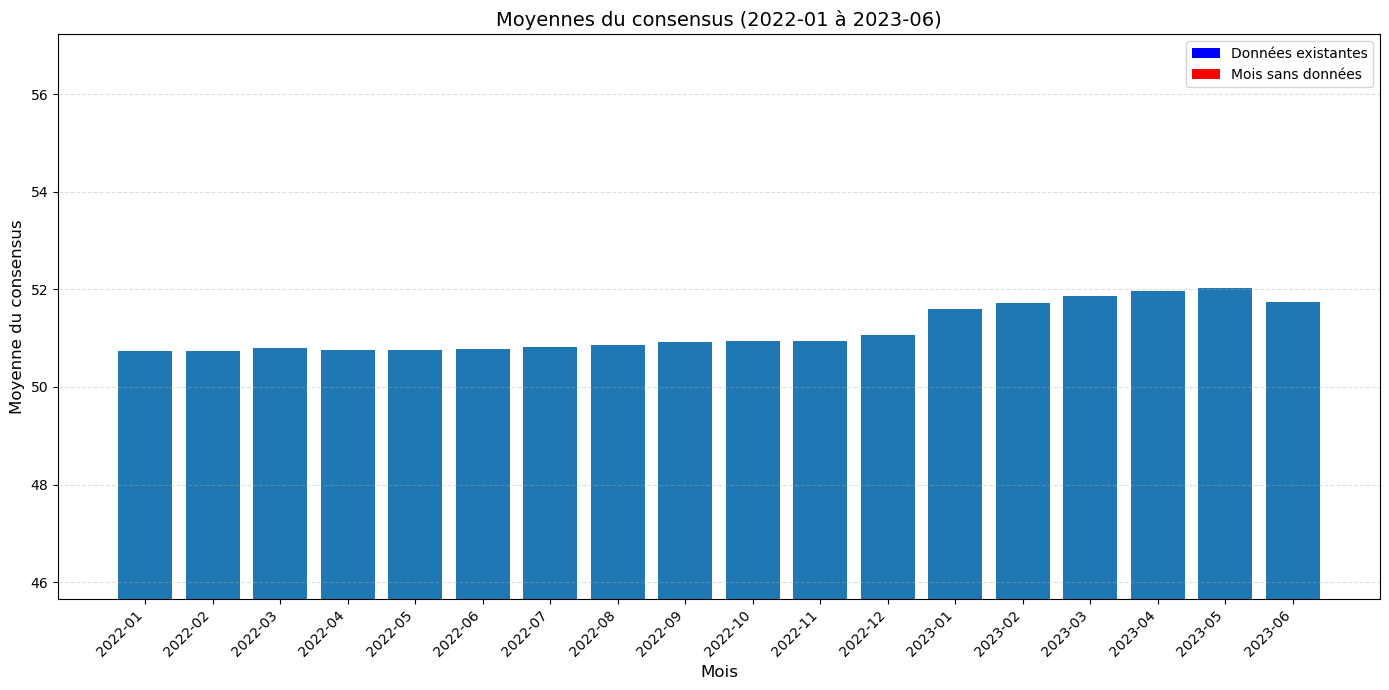

In [20]:
df['period'] = pd.to_datetime(df['period'])
period_start = '2022-01'
period_end = '2023-06'

# Création de l'échelle temporelle complète
full_months = pd.period_range(start=period_start, end=period_end, freq='M')

# Calcul des moyennes avec tous les mois forcés
moyennes = (
    df.groupby(df['period'].dt.to_period('M'))['consensus']
    .mean()
    .reindex(full_months)
)
plt.figure(figsize=(14, 7))
plt.bar(moyennes.index.astype(str), moyennes.fillna(0))
plt.title(f"Moyennes du consensus ({period_start} à {period_end})", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Moyenne du consensus", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(handles=legend_elements)
plt.axhline(0, color='black', linewidth=0.8)
if not moyennes.isna().all():
    y_min = moyennes.min() * 0.9 if moyennes.min() > 0 else moyennes.min() * 1.1
    y_max = moyennes.max() * 1.1 if moyennes.max() > 0 else moyennes.max() * 0.9
    plt.ylim(y_min, y_max)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

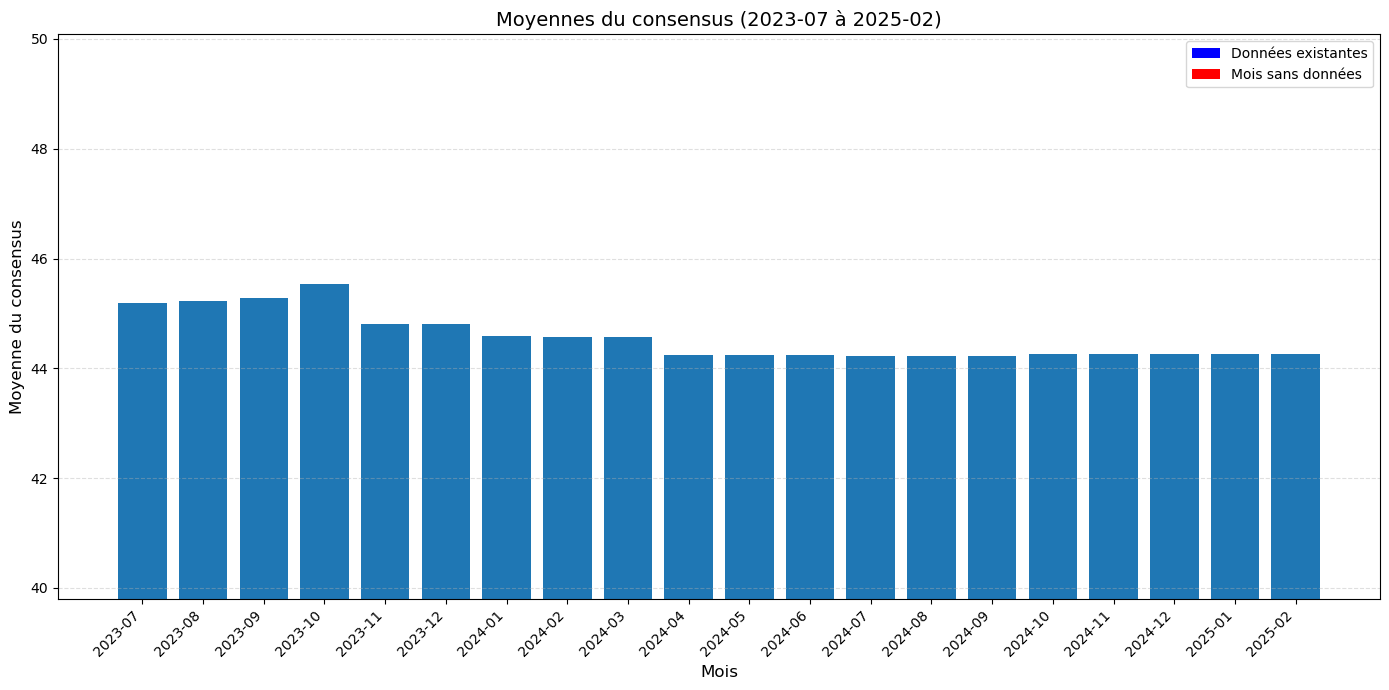

In [22]:
df['period'] = pd.to_datetime(df['period'])
period_start = '2023-07'
period_end = '2025-02'

# Création de l'échelle temporelle complète
full_months = pd.period_range(start=period_start, end=period_end, freq='M')

# Calcul des moyennes avec tous les mois forcés
moyennes = (
    df.groupby(df['period'].dt.to_period('M'))['consensus']
    .mean()
    .reindex(full_months)
)
plt.figure(figsize=(14, 7))
plt.bar(moyennes.index.astype(str), moyennes.fillna(0))
plt.title(f"Moyennes du consensus ({period_start} à {period_end})", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Moyenne du consensus", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(handles=legend_elements)
plt.axhline(0, color='black', linewidth=0.8)
if not moyennes.isna().all():
    y_min = moyennes.min() * 0.9 if moyennes.min() > 0 else moyennes.min() * 1.1
    y_max = moyennes.max() * 1.1 if moyennes.max() > 0 else moyennes.max() * 0.9
    plt.ylim(y_min, y_max)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
def detect_score_improvement(df, threshold=10):
    results = []
    df['period'] = pd.to_datetime(df['period'])
    df = df.sort_values(by=['name', 'score_kind', 'period'])
    score_columns = ['first_quartile', 'third_quartile', 'consensus']
    for score_type in df['score_kind'].unique():
        subset = df[df['score_kind'] == score_type].copy() 
        for score_col in score_columns:
            subset[f'{score_col}_diff'] = subset.groupby('name')[score_col].diff()
            improved = subset[subset[f'{score_col}_diff'] >= threshold]
            for _, row in improved.iterrows():
                results.append({
                    'Entreprise': row['name'],
                    'Début': subset[(subset['name'] == row['name']) & 
                                    (subset[score_col] == row[score_col] - row[f'{score_col}_diff'])]['period'].min(),
                    'Fin': row['period'],
                    'Type de Score': score_type,
                    'Mesure': score_col  # Indiquer si l'amélioration est sur Q1, Q3 ou consensus
                })
    return pd.DataFrame(results)

improved_companies = detect_score_improvement(df)
print(improved_companies)

In [ ]:
df['period'] = pd.to_datetime(df['period'])

# Calculer les statistiques par période
stats_by_period = df.groupby('period')['consensus'].describe()

# Afficher le résultat
print(stats_by_period)

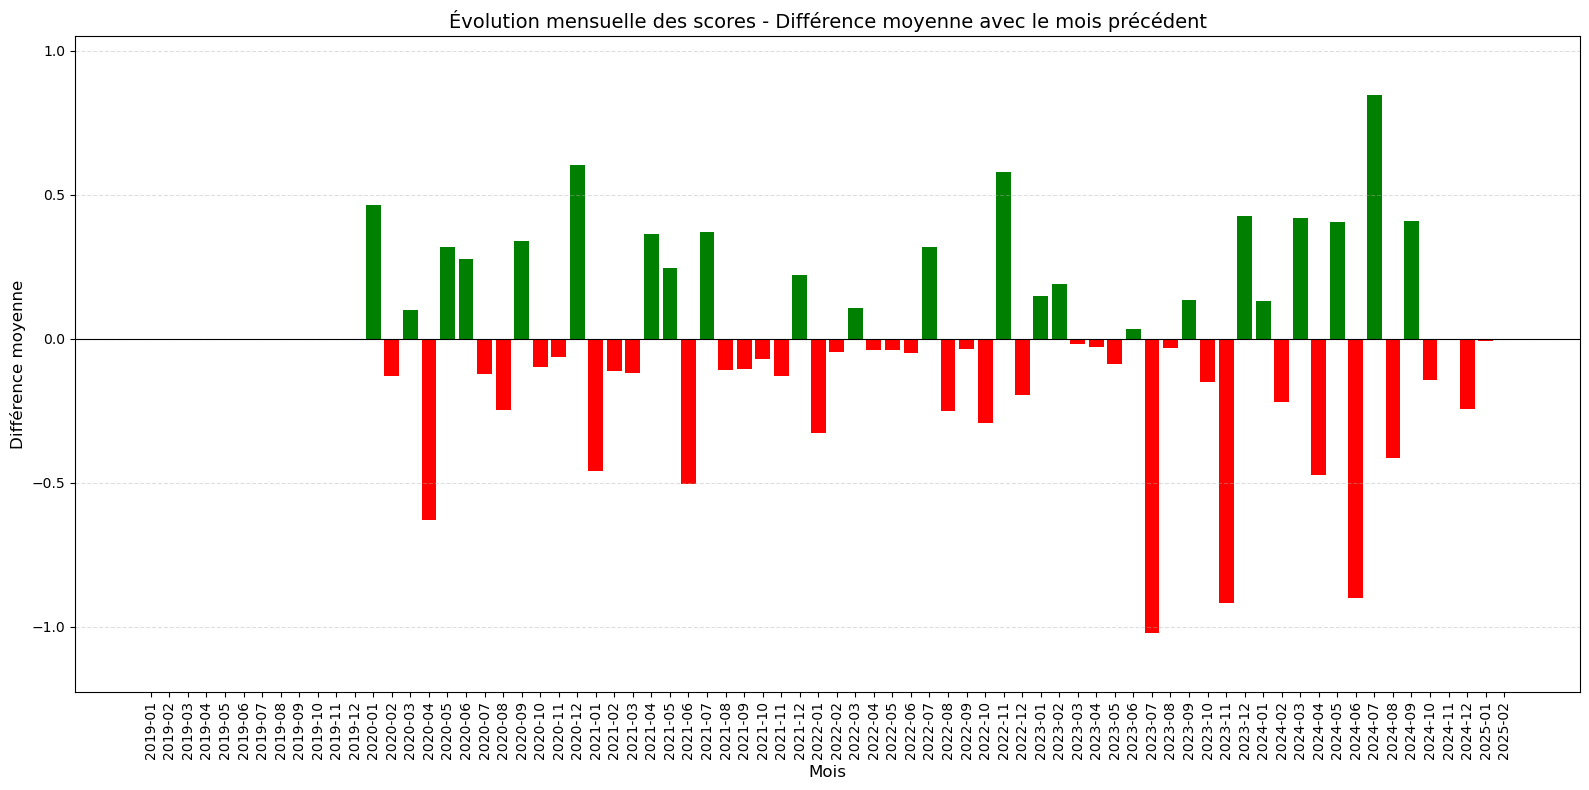

In [25]:
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values(['name', 'period'])

# 2. Calcul des différences mensuelles
df['prev_score'] = df.groupby('name')['consensus'].shift(1)
df['score_diff'] = df['consensus'] - df['prev_score']

# 3. Filtrage des données valides (où le mois précédent existe)
valid_diffs = df.dropna(subset=['prev_score'])

# 4. Calcul des moyennes mensuelles
monthly_avg_diff = valid_diffs.groupby(valid_diffs['period'].dt.to_period('M'))['score_diff'].mean()

# 5. Création de la période complète
all_months = pd.period_range(
    start=df['period'].min().to_period('M'),
    end=df['period'].max().to_period('M'),
    freq='M'
)
complete_avg_diff = monthly_avg_diff.reindex(all_months)

# 6. Visualisation complète
plt.figure(figsize=(16, 8))

# Barres colorées selon la valeur
colors = []
for val in complete_avg_diff:
    if pd.isna(val):
        colors.append('lightgray')
    elif val > 0:
        colors.append('green')  # Amélioration
    else:
        colors.append('red')    # Dégradation

bars = plt.bar(complete_avg_diff.index.astype(str), 
               complete_avg_diff.fillna(0),
               color=colors)

# Personnalisation du graphique
plt.title("Évolution mensuelle des scores - Différence moyenne avec le mois précédent", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Différence moyenne", fontsize=12)
plt.xticks(rotation=90, ha='center')
plt.axhline(0, color='black', linewidth=0.8)



# Ajustement dynamique des limites Y
if not complete_avg_diff.isna().all():
    buffer = max(0.1, complete_avg_diff.abs().max() * 0.2)
    plt.ylim(complete_avg_diff.min() - buffer, 
             complete_avg_diff.max() + buffer)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



AttributeError: module 'matplotlib.pyplot' has no attribute 'PercentFormatter'

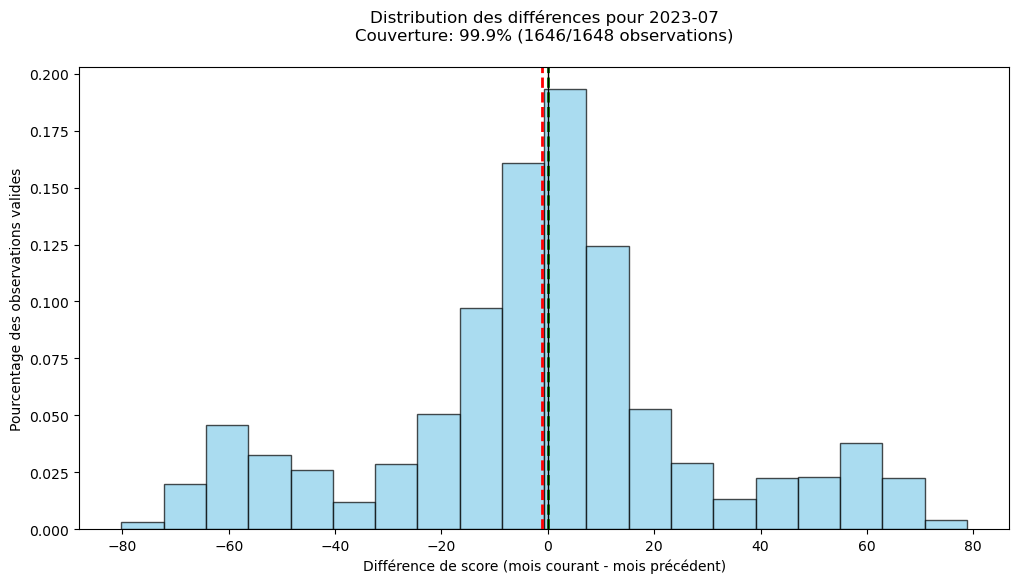

In [47]:
def plot_monthly_diff_histogram():
    # Saisie du mois
    month_input = input("Entrez le mois à analyser (format YYYY-MM) : ")
    
    try:
        selected_month = pd.to_datetime(month_input).to_period('M')
        
        # 1. Comptage des observations totales pour le mois
        month_data = df[df['period'].dt.to_period('M') == selected_month]
        total_obs = len(month_data)
        
        # 2. Filtrage des observations valides (avec mois précédent)
        valid_data = month_data.dropna(subset=['prev_score'])
        valid_obs = len(valid_data)
        
        if valid_obs == 0:
            print(f"\nAucune donnée valide pour {selected_month}")
            return
        
        # 3. Calcul du pourcentage (en observations, pas en entreprises uniques)
        percentage_valid = (valid_obs / total_obs) * 100
        
        # 4. Préparation de l'histogramme
        plt.figure(figsize=(12, 6))
        
        # Histogramme en pourcentage
        counts, bins, patches = plt.hist(valid_data['score_diff'],
                                        bins=20,
                                        color='skyblue',
                                        edgecolor='black',
                                        alpha=0.7,
                                        weights=np.ones_like(valid_data['score_diff']) / valid_obs)
        
        # Lignes de référence
        mean_diff = valid_data['score_diff'].mean()
        median_diff = valid_data['score_diff'].median()
        
        plt.axvline(mean_diff, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_diff:.2f}')
        plt.axvline(median_diff, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_diff:.2f}')
        plt.axvline(0, color='black', linewidth=1)
        
        # Titre avec les stats
        plt.title(f"Distribution des différences pour {selected_month}\n"
                 f"Couverture: {percentage_valid:.1f}% ({valid_obs}/{total_obs} observations)", 
                 pad=20, fontsize=12)
        
        # Labels et légende
        plt.xlabel("Différence de score (mois courant - mois précédent)")
        plt.ylabel("Pourcentage des observations valides")
        plt.gca().yaxis.set_major_formatter(plt.PercentFormatter(1.0))
        plt.legend()
        
        # Statistiques détaillées
        stats_text = (f"Couverture: {percentage_valid:.1f}%\n"
                     f"Moyenne: {mean_diff:.2f}\n"
                     f"Médiane: {median_diff:.2f}\n"
                     f"Écart-type: {valid_data['score_diff'].std():.2f}")
        
        plt.annotate(stats_text,
                    xy=(0.98, 0.95),
                    xycoords='axes fraction',
                    ha='right',
                    va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Affichage console
        print(f"\nAnalyse pour {selected_month}:")
        print(f"Observations totales: {total_obs}")
        print(f"Observations valides: {valid_obs} ({percentage_valid:.1f}%)")
        print(valid_data['score_diff'].describe())
        
    except ValueError:
        print("Format de date invalide. Utilisez YYYY-MM")

# Préparation des données (identique à avant)
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values(['name', 'period'])
df['prev_score'] = df.groupby('name')['consensus'].shift(1)
df['score_diff'] = df['consensus'] - df['prev_score']

# Exécution
plot_monthly_diff_histogram()